In [1]:
import numpy as np
import random
from scipy.stats import norm
import openpyxl as opx
import time
from sklearn.model_selection import KFold
from itertools import product
import matplotlib.pyplot as plt

In [2]:
def gaussian_distribution(days_distribution):
    # Parámetros de la campana de Gauss deseada
    mean = days_distribution / 2
    std_dev = 8.8

    # Crear un rango de valores en el eje x
    x_values = np.linspace(1, days_distribution, days_distribution)
    y_values = norm.pdf(x_values, mean, std_dev)

    # Ajustar la campana de Gauss para que la suma de las probabilidades sea 1
    sum_y_values = np.sum(y_values)
    ajuste = (1 - sum_y_values) / days_distribution

    for i in range(len(y_values)):
        y_values[i] += ajuste

    #print("Distribución Objetivo:\n", y_values)
    #suma = np.sum(y_values)
    #print("Suma:", suma)

    return y_values, x_values

In [3]:
# Función de inicialización de la población
def initialize_population(population_size, genome_size, remainder):
    # Crear un arreglo con valores aleatorios entre 0 y 0.5
    population = [np.random.uniform(0, 0.5, genome_size) for _ in range(population_size)]

    # Ajustar algunos valores para que la suma sea igual al remanente
    for i in range(population_size):
        population[i] = population[i] / np.sum(population[i]) * remainder

    #print(np.array(population))
    #print("Suma de cada fila:", np.sum(population, axis=1))
    return np.array(population)

In [4]:
# Función de fitness con el error cuadrático medio
def mse_fitness(y_true, y_pred):
  # Calcula la diferencia entre los valores reales y predichos
  error = y_true - y_pred

  # Calcula el cuadrado del error
  squared_error = np.square(error)

  # Calcula la media del cuadrado del error
  mse = (1 / (1 + np.mean(squared_error)))
  return mse

In [5]:
# Cruce de un punto 
def one_point_crossover(parent1, parent2, crossover_rate):
    if np.random.rand() < crossover_rate:
        crossover_point = np.random.randint(1, len(parent1) - 1)
        #print("Punto de cruce:", crossover_point)
        child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
        child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
        return child1, child2
    else:
        return parent1, parent2

In [6]:
# Mutación uniforme de un individuo
def mutate(child, mutation_rate):
    mask = np.random.rand(len(child)) < mutation_rate
    child[mask] = np.random.rand(sum(mask))
    return child

In [7]:
def tournament_selection(population, fitness, k, num_selections):
    selected_individuals = []
    
    for _ in range(num_selections):
        # Seleccionar k individuos al azar para el torneo
        tournament = random.sample(range(len(population)), k)
        
        # Obtener el índice del individuo con el mejor fitness
        tournament_winner = np.max(tournament, key=lambda index: fitness[index])
        
        # Añadir el individuo seleccionado a la lista de individuos seleccionados
        selected_individuals.append(population[tournament_winner])
    
    return selected_individuals

In [8]:
# Algoritmo genético
def genetic_algorithm(target_distribution, real_progress, population_size=50, crossover_rate=0.8, mutation_rate=0.1, generations=3100):
    progress_days = sum(1 for value in real_progress if value is not None)
    genome_size = len(target_distribution) - progress_days
    # Eliminamos los días que ya han pasado
    target_dist_to_end = target_distribution[progress_days:]
    
    # Inicializar la población arreglos que suman el remanente para terminar las tareas
    remainder = 1 - sum(value for value in real_progress if value is not None)
    population = initialize_population(population_size, genome_size, remainder)
    evolution = []

    contGeneration = 0

    for generation in range(generations):
        # Calcular la aptitud de cada individuo en la población
        fitness_values = np.array([mse_fitness(individual, target_dist_to_end) for individual in population])
        #fitness_values = np.array([chisquare_fitness(individual, target_dist_to_end) for individual in population])

        # Seleccionar los dos mejores individuos
        #selected_indices = np.argsort(fitness_values)[-2:]
        #parents = population[selected_indices]

        selected_indices = random.sample(range(len(fitness_values)), 4)
        if fitness_values[selected_indices[0]] > fitness_values[selected_indices[1]]:
            index1 = selected_indices[0]
        else:
            index1 = selected_indices[1]

        if fitness_values[selected_indices[2]] > fitness_values[selected_indices[3]]:
            index2 = selected_indices[2]
        else:
            index2 = selected_indices[3]

        indx = [index1, index2]
        parents = population[indx]
        #print("Padres:", parents)   

        # Cruzar y mutación para obtener nuevos individuos
        children = [mutate(child, mutation_rate) for child in one_point_crossover(*parents, crossover_rate)]
        #print("Hijos:", children)

        # Reemplazar los dos peores individuos en la población con los nuevos individuos
        worst_indices = np.argsort(fitness_values)[:2]
        population[worst_indices] = children

        # Imprimir la aptitud del mejor individuo en esta generación
        best_fitness = np.max(fitness_values)
        evolution.append({"Generación": generation + 1, "Mejor Aptitud": best_fitness})
        
        contGeneration = generation + 1
        
        if best_fitness >= 0.99995:
            break;
        #print("Generación:", generation + 1, "Mejor Aptitud", best_fitness)

    # Devolver el mejor individuo al final del algoritmo
    best_index = np.argmax(fitness_values)
    best_individual = population[best_index]

    data_convergence = [{"Best Fitness": best_fitness, "Generations": contGeneration, "Population": population_size, "Crossover Rate": crossover_rate, "Mutation_Rate": mutation_rate}]
    
    return best_individual, data_convergence, evolution

In [ ]:
# Validación de convergencia
# Crear un libro de trabajo en blanco
wb = opx.Workbook()

# Agregar una hoja (por defecto ya hay una hoja activa)
hoja_activa = wb.active
hoja_activa.title = "General"  # Cambia el nombre de la hoja si lo deseas

#Ejecucipon de la tarea
work_days = 44
pruebas = 21
# Se crea una simulación de la distribución de probabilidad de la campana de Gauss para una tarea planificada.
target_distribution, x_values = gaussian_distribution(work_days)

# Simulamos un avance real de la tarea que representa un atraso del 20%
real_progress = np.array([target_distribution[i] * 0.8 if i < 10 else None for i in range(work_days)])

hoja_activa['A1'] = "Test"
hoja_activa['B1'] = "Best Fitness"
hoja_activa['C1'] = "Generations"
hoja_activa['D1'] = "Population"
hoja_activa['E1'] = "Crossover Rate"
hoja_activa['F1'] = "Mutation Rate"
hoja_activa['G1'] = "Time"

# Ejecutar el algoritmo genético
for i in range(pruebas):
    #Números aleatorios para la población
    pop = random.randint(20, 124)
    #Números aleatorios para cruce
    cru = round(random.uniform(0.704,0.9564), 4)
    #Números aleatorios para mutación
    mut = round(random.uniform(0.0046, 0.0355), 4)

    inicio = time.time()
    best_solution, data_convergence, evolution = genetic_algorithm(target_distribution, real_progress, population_size=pop, crossover_rate=cru, mutation_rate=mut)
    fin = time.time()
    tiempo_ejecucion = fin - inicio
    hoja_activa.append([str(i + 1), data_convergence[0]["Best Fitness"], data_convergence[0]["Generations"], data_convergence[0]["Population"], data_convergence[0]["Crossover Rate"], 
                        data_convergence[0]["Mutation_Rate"], round(tiempo_ejecucion, 4)])
    # Medición del tiempo de ejecución
    
    evolution_sheet = wb.create_sheet("Test" + str(i + 1))
    evolution_sheet.append(["Generación", "Mejor Aptitud T" + str(i + 1)])

    for e in evolution:
        evolution_sheet.append([e["Generación"], e["Mejor Aptitud"]])
    
    print(f"Test {i + 1} - Best Fitness: {data_convergence[0]['Best Fitness']}, Generations: {data_convergence[0]['Generations']}, Population: {data_convergence[0]['Population']}, Crossover Rate: {data_convergence[0]['Crossover Rate']}, Mutation Rate: {data_convergence[0]['Mutation_Rate']}, Time: {round(tiempo_ejecucion, 4)}")

wb.save(f"AGTest.xlsx")

In [9]:
# Generar proyectos de prueba (simulación de datos)
def generar_proyectos(num_proyectos, num_dias, retraso):
    proyectos = []
    for _ in range(num_proyectos):
        recursos_planeados = gaussian_distribution(num_dias)[0]
        recursos_con_retraso = recursos_planeados[:10] * (1 - retraso)
        recursos_planeados[:10] = recursos_con_retraso
        proyectos.append(recursos_planeados)
    return np.array(proyectos)

In [10]:
# Función para calcular las métricas de rendimiento
def calcular_metricas(proyectos_iniciales, proyectos_finales):
    desviaciones_estandar = []
    cumplimientos_objetivos = []
    eficiencias_recursos = []

    for inicial, final in zip(proyectos_iniciales, proyectos_finales):
        desviacion = np.std(final - inicial)
        desviaciones_estandar.append(desviacion)
        
        cumplimiento = np.all(final >= 0)  # Supongamos que el objetivo es no tener recursos negativos
        cumplimientos_objetivos.append(cumplimiento)
        
        eficiencia = np.mean(final / inicial)  # Ejemplo simplificado
        eficiencias_recursos.append(eficiencia)

    return {
        "Desviacion Estandar": np.mean(desviaciones_estandar),
        "Cumplimiento de Objetivos": np.mean(cumplimientos_objetivos),
        "Eficiencia de Recursos": np.mean(eficiencias_recursos)
    }

In [11]:
# Algoritmo genético
def genetic_algorithmVC(target_distribution, population_size=50, crossover_rate=0.8, mutation_rate=0.1, generations=3100):
    progress_days = 10
    genome_size = len(target_distribution) - progress_days

    remainder = 1 - sum(target_distribution[:10])
    # Eliminamos los días que ya han pasado
    target_real = target_distribution[:10]
    target_dist_to_end = target_distribution[progress_days:]
    
    # Inicializar la población arreglos que suman el remanente para terminar las tareas
    population = initialize_population(population_size, genome_size, remainder)

    for _ in range(generations):
        # Calcular la aptitud de cada individuo en la población
        fitness_values = np.array([mse_fitness(individual, target_dist_to_end) for individual in population])
        #fitness_values = np.array([chisquare_fitness(individual, target_dist_to_end) for individual in population])

        # Seleccionar los dos mejores individuos
        #selected_indices = np.argsort(fitness_values)[-2:]
        #parents = population[selected_indices]

        selected_indices = random.sample(range(len(fitness_values)), 4)
        if fitness_values[selected_indices[0]] > fitness_values[selected_indices[1]]:
            index1 = selected_indices[0]
        else:
            index1 = selected_indices[1]

        if fitness_values[selected_indices[2]] > fitness_values[selected_indices[3]]:
            index2 = selected_indices[2]
        else:
            index2 = selected_indices[3]

        indx = [index1, index2]
        parents = population[indx]
        #print("Padres:", parents)   

        # Cruzar y mutación para obtener nuevos individuos
        children = [mutate(child, mutation_rate) for child in one_point_crossover(*parents, crossover_rate)]
        #print("Hijos:", children)

        # Reemplazar los dos peores individuos en la población con los nuevos individuos
        worst_indices = np.argsort(fitness_values)[:2]
        population[worst_indices] = children

        # Imprimir la aptitud del mejor individuo en esta generación
        best_fitness = np.max(fitness_values)
        
        if best_fitness >= 0.99995:
            break;
        #print("Generación:", generation + 1, "Mejor Aptitud", best_fitness)

    # Devolver el mejor individuo al final del algoritmo
    best_index = np.argmax(fitness_values)
    best_individual = population[best_index]

    unidos = np.concatenate((target_real, best_individual))
    return unidos

Probando con Tamaño de Población: 45, Probabilidad de Cruce: 0.7275, Probabilidad de Mutación: 0.0072, Número de Generaciones: 50
Probando con Tamaño de Población: 45, Probabilidad de Cruce: 0.7275, Probabilidad de Mutación: 0.0072, Número de Generaciones: 100
Probando con Tamaño de Población: 45, Probabilidad de Cruce: 0.7275, Probabilidad de Mutación: 0.0072, Número de Generaciones: 200
Probando con Tamaño de Población: 45, Probabilidad de Cruce: 0.7275, Probabilidad de Mutación: 0.0072, Número de Generaciones: 300
Probando con Tamaño de Población: 45, Probabilidad de Cruce: 0.7275, Probabilidad de Mutación: 0.0072, Número de Generaciones: 500
Probando con Tamaño de Población: 45, Probabilidad de Cruce: 0.7275, Probabilidad de Mutación: 0.0168, Número de Generaciones: 50
Probando con Tamaño de Población: 45, Probabilidad de Cruce: 0.7275, Probabilidad de Mutación: 0.0168, Número de Generaciones: 100
Probando con Tamaño de Población: 45, Probabilidad de Cruce: 0.7275, Probabilidad de 

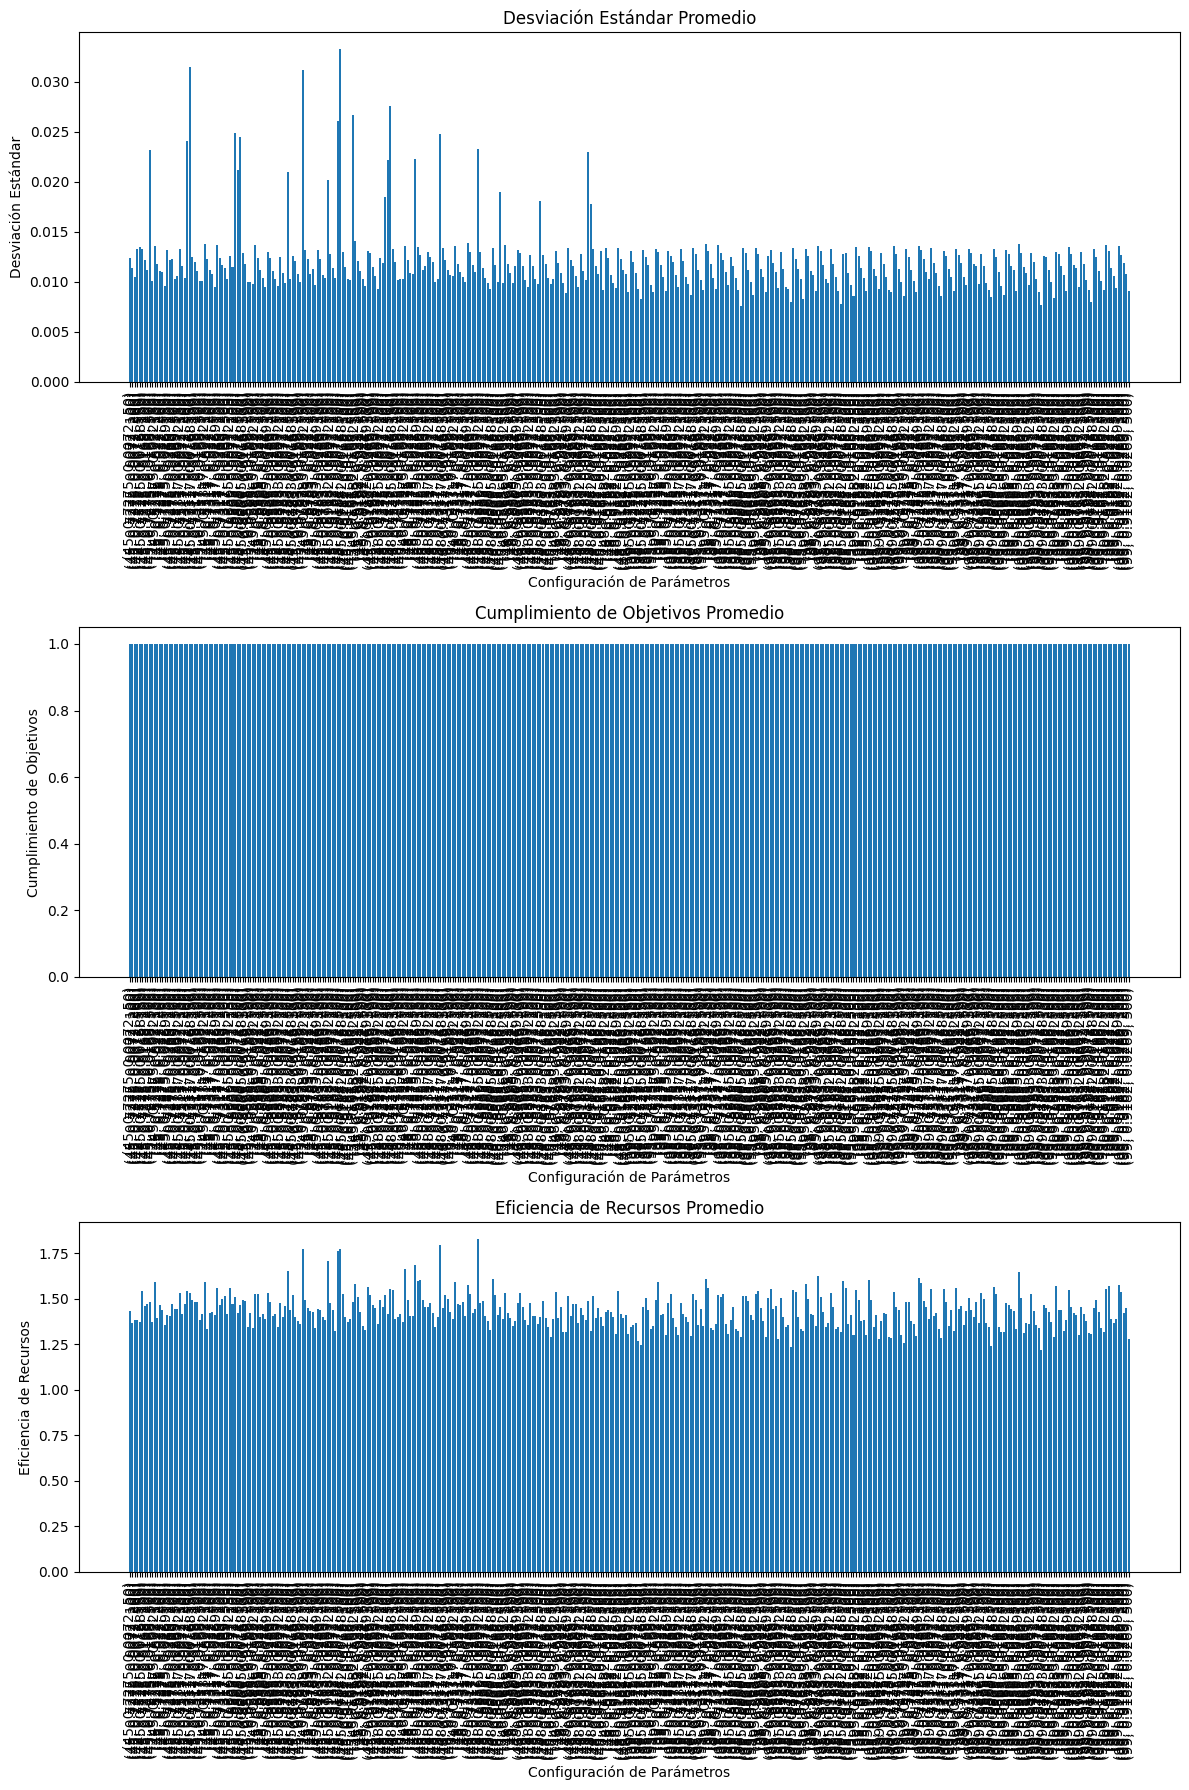

In [12]:
# Parámetros de la simulación
num_proyectos = 10
num_dias = 44
retraso = 0.1
k = 5  # Número de folds para la validación cruzada

# Generar proyectos de prueba
proyectos_prueba = generar_proyectos(num_proyectos, num_dias, retraso)

# Rango de valores para los parámetros
pop_size_values = [45, 48, 95, 99]
cross_prob_values = [0.7275, 0.7317, 0.8565, 0.8783, 0.9182]
mut_prob_values = [0.0072, 0.0168, 0.022, 0.0269]
num_gen_values = [50, 100, 200, 300, 500]

# Realizar grid search con validación cruzada
resultados = []

# Realizar grid search con validación cruzada
mejor_puntaje = -np.inf
mejores_parametros = None

for pop_size, cross_prob, mut_prob, num_gen in product(pop_size_values, cross_prob_values, mut_prob_values, num_gen_values):
    print(f"Probando con Tamaño de Población: {pop_size}, Probabilidad de Cruce: {cross_prob}, Probabilidad de Mutación: {mut_prob}, Número de Generaciones: {num_gen}")
    kf = KFold(n_splits=k)
    resultados_desviacion_estandar = []
    resultados_cumplimiento_objetivos = []
    resultados_eficiencia_recursos = []
    
    for train_index, test_index in kf.split(proyectos_prueba):
        proyectos_train, proyectos_test = proyectos_prueba[train_index], proyectos_prueba[test_index]
        
        # Aplicar el algoritmo genético en el conjunto de entrenamiento
        resultados_train = [genetic_algorithmVC(proyecto, pop_size, cross_prob, mut_prob, num_gen) for proyecto in proyectos_train]
        
        # Evaluar el algoritmo en el conjunto de prueba
        resultados_test = [genetic_algorithmVC(proyecto, pop_size, cross_prob, mut_prob, num_gen) for proyecto in proyectos_test]
        
        # Calcular métricas para el conjunto de prueba
        metricas = calcular_metricas(proyectos_test, resultados_test)
        resultados_desviacion_estandar.append(metricas["Desviacion Estandar"])
        resultados_cumplimiento_objetivos.append(metricas["Cumplimiento de Objetivos"])
        resultados_eficiencia_recursos.append(metricas["Eficiencia de Recursos"])
    
    # Promediar los resultados de las métricas
    desviacion_estandar_promedio = np.mean(resultados_desviacion_estandar)
    cumplimiento_objetivos_promedio = np.mean(resultados_cumplimiento_objetivos)
    eficiencia_recursos_promedio = np.mean(resultados_eficiencia_recursos)

    # Guardar resultados
    resultados.append({
        "Parametros": (pop_size, cross_prob, mut_prob, num_gen),
        "Desviacion Estandar": desviacion_estandar_promedio,
        "Cumplimiento de Objetivos": cumplimiento_objetivos_promedio,
        "Eficiencia de Recursos": eficiencia_recursos_promedio
    })
    
    # Evaluar el puntaje global (puedes definir un criterio de evaluación compuesto)
    puntaje_global = eficiencia_recursos_promedio  # Ejemplo simplificado
    
    if puntaje_global > mejor_puntaje:
        mejor_puntaje = puntaje_global
        mejores_parametros = (pop_size, cross_prob, mut_prob, num_gen)
    
# Extraer los mejores parámetros
mejores_parametros = max(resultados, key=lambda x: x["Eficiencia de Recursos"])["Parametros"]

print("Mejores Parámetros Encontrados:")
print(f"Tamaño de la Población: {mejores_parametros[0]}")
print(f"Probabilidad de Cruce: {mejores_parametros[1]}")
print(f"Probabilidad de Mutación: {mejores_parametros[2]}")
print(f"Número de Generaciones: {mejores_parametros[3]}")

# Visualización de los resultados
desviaciones = [r["Desviacion Estandar"] for r in resultados]
cumplimientos = [r["Cumplimiento de Objetivos"] for r in resultados]
eficiencias = [r["Eficiencia de Recursos"] for r in resultados]
parametros = [r["Parametros"] for r in resultados]

# Promedios de las métricas
print("Desviación Estándar Promedio:", np.mean(desviaciones))
print("Cumplimiento de Objetivos Promedio:", np.mean(cumplimientos))
print("Eficiencia de Recursos Promedio:", np.mean(eficiencias))

# Crear gráfico de barras para las métricas
fig, ax = plt.subplots(3, 1, figsize=(12, 18))

ax[0].bar(range(len(desviaciones)), desviaciones)
ax[0].set_title('Desviación Estándar Promedio')
ax[0].set_xlabel('Configuración de Parámetros')
ax[0].set_ylabel('Desviación Estándar')
ax[0].set_xticks(range(len(parametros)))
ax[0].set_xticklabels(parametros, rotation=90)

ax[1].bar(range(len(cumplimientos)), cumplimientos)
ax[1].set_title('Cumplimiento de Objetivos Promedio')
ax[1].set_xlabel('Configuración de Parámetros')
ax[1].set_ylabel('Cumplimiento de Objetivos')
ax[1].set_xticks(range(len(parametros)))
ax[1].set_xticklabels(parametros, rotation=90)

ax[2].bar(range(len(eficiencias)), eficiencias)
ax[2].set_title('Eficiencia de Recursos Promedio')
ax[2].set_xlabel('Configuración de Parámetros')
ax[2].set_ylabel('Eficiencia de Recursos')
ax[2].set_xticks(range(len(parametros)))
ax[2].set_xticklabels(parametros, rotation=90)

plt.tight_layout()
plt.show()